In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
    
    if(False): # This does atomics - very slow
        C = tf.zeros([N, K])
        i, j, k = tf.indices([N, K, M])
        tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
    else: # This does a loop - much faster
        C = tf.buffer([N, K])
        i, j = C.indices
        s = tf.zeros([N, K], tf.float32)
        def loop_body(k):
            s.set(s + A[i, k] * Bt[j, k])
        tf.loop(loop_body, 0, M, 1)
        C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
matmul:
  Kernel count: 2
  Intermediate buffers: 1
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 368
  IR Compile time: 0.476400 ms
  Compiler time: 1333.282959 ms



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[6.3005266 6.7512145 5.9407563 ... 6.703408  5.5320415 6.206746 ]
 [5.862539  5.7317433 7.491395  ... 5.8295035 5.636983  5.433282 ]
 [8.11406   7.270631  9.227268  ... 8.114723  7.754997  7.369275 ]
 ...
 [7.6099453 6.5757346 6.8700953 ... 6.81543   7.0844197 6.106869 ]
 [7.4997344 7.7530875 7.733942  ... 6.530438  7.05992   6.794213 ]
 [7.435955  7.3977914 8.0672    ... 7.041428  7.2183385 6.40048  ]]
[[6.300527  6.751215  5.940756  ... 6.7034082 5.5320406 6.206745 ]
 [5.8625393 5.7317433 7.491395  ... 5.829503  5.636983  5.4332814]
 [8.114059  7.27063   9.22727   ... 8.114723  7.7549973 7.369276 ]
 ...
 [7.6099463 6.575734  6.8700953 ... 6.81543   7.0844193 6.1068697]
 [7.499735  7.7530885 7.733943  ... 6.5304384 7.0599203 6.794213 ]
 [7.435954  7.397791  8.0672    ... 7.0414276 7.218338  6.4004803]]
Error: 4.8679208e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.000887876017144674
TensorFrost:  0.001311738806281235
TF/NP:  1.4773896140360496


In [6]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(8, 14)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

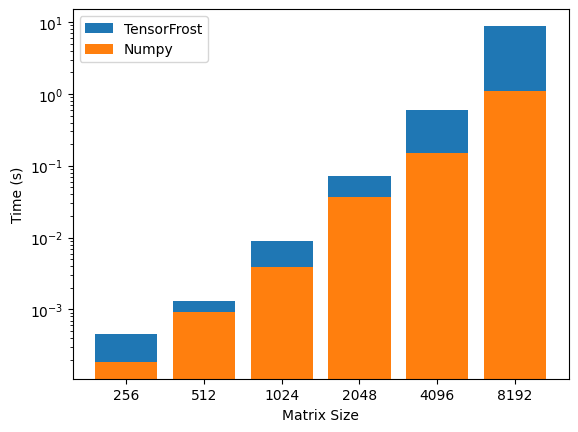

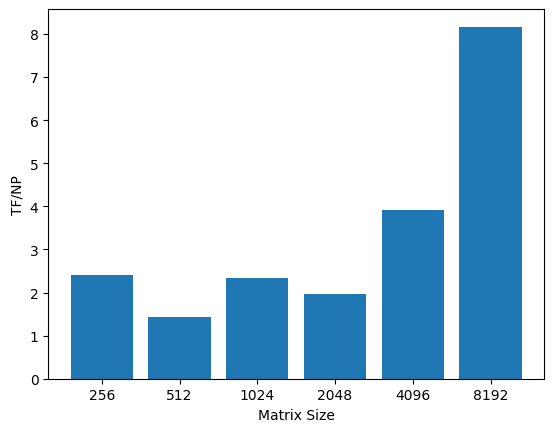

[0.00044831654931482023, 0.0012909492369621032, 0.009049911756773252, 0.07102573712666829, 0.5879772901535034, 8.839786052703857]
[0.00018611585275212324, 0.0009074431798419156, 0.0038837240647900013, 0.03617855480739048, 0.15014263561793736, 1.082336187362671]


In [7]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)